In [5]:
# Comparison of pvlib's uncertainty modelling to SunSolve's new P90 tool.
# Testing how adding error functions to pvlib inputs and then repeatedly simulating
# the system with random error gives a distribution of yields.

In [6]:
# Set up working folder
import os, sys
if "google.colab" in sys.modules:
    from google.colab import drive, data_table
    # Mount Google Drive
    drive.mount("/content/drive")

    # Change the working directory to wherever you have saved this file on your drive
    folder = "/content/drive/MyDrive/Colab Notebooks/Uncertainty Colabs"
    os.chdir(folder)
else:
    # If Google drive is not available, then run from the current folder
    folder = os.getcwd()

# Check if the necessary files/folders are available, or clone them from GitHub
necessary_files = ["Data", "SunSolveLogo.svg", "README.md", "pvl_p90_client-0.1.0.156+dev-py3-none-any.whl", "UncertaintyFunctions.ipynb"]
if not all(i in os.listdir() for i in necessary_files):
    if not "SunSolve P90" in os.listdir() or not all(i in os.listdir("SunSolve P90") for i in necessary_files):
        os.mkdir("SunSolve P90")
        !git clone https://github.com/SF-PVL/P90-Notebook.git "SunSolve P90"
    os.chdir("SunSolve P90")

# Install the P90 client (a pip dependency error may occur for protobuf, but can be ignored)
%pip install pvl_p90_client-0.1.0.156+dev-py3-none-any.whl --quiet

Note: you may need to restart the kernel to use updated packages.


In [194]:
# Load helper file functions, log in to your PV Lighthouse account and start running a test simulation
%run "UncertaintyFunctions.ipynb"

# Set uncertainty simulation constants (time scales with N_SIMS*N_YEARS, 5000*5 ≈ 120 seconds in P90, but around 20 minutes in pvlib)
N_SIMS = 6000    # Need to reduce this here, as pvlib will take hours to do thousands of simulations, generally.
N_YEARS = 12
simulation_options = build_simulation_options(number_of_years=N_YEARS, number_of_simulations=N_SIMS)

# Set P-value preferences
p_values = [10, 50, 90]     # e.g. [50, 90, 95] -> P50, P90, P95
p_min = 0.30                # The minimum fraction of P50 to be binned on histograms (extreme here to help validation)
p_delta = 0.02              # The bin size for histograms
result_options = build_result_options(p_min=p_min, p_delta=p_delta, p_values=p_values)

# Collect weather data: sydney.pvw file is provided as part of the source
weather_file_path = "Data/sydney.pvw"
weather_data = load_weather_data_from_pvw_file(weather_file_path)

# Set up system
module_info = build_module_info(length=2.0, width=1.0, bifaciality=0.8)

system_info = build_system_info(
    modules_per_string=1,
    fallback_module_tilt_in_degrees=30,
    number_of_inverters=1,
    num_strings_per_inverter=1,
    row_pitch_in_m=5.6,
    azimuth_in_degrees=90            # Direction modules face for positive tilt. 0=North, 90=East, 180=South
)

electrical_settings = build_electrical_settings(
    inverter_efficiency=0.98,
    module_to_module_mismatch=0.01,
    string_wiring_loss=0.01,
    inverter_wiring_loss=0.01,
    max_power_tracking_loss=0.0
)

thermal_settings = build_thermal_settings(uc=25, uv=1.2, alpha=0.9)

optical_settings = build_optical_settings(fallback_albedo=0.2,
    fallback_soiling_front=0.02, fallback_soiling_rear=0.002,
    isotropic_multiplier_front=1)

operational_settings = build_operational_settings(annual_degradation_rate=0.005,
    curtailment=0.02, availability=0.98)

2025-10-09 21:31:21,952 - INFO - Connected to P90 service at middleware.pvlighthouse.com.au
2025-10-09 21:31:22,075 - INFO - P90 client connection closed


Connecting to PV Lighthouse...
Authenticating...
Authentication successful!
Loading time step data...
Loaded 8760 weather data points


In [195]:
# View irradiance data for specific day. If plot is displayed multiple times, this is a VS Code issue. Try restarting the kernel.
interactive_weather_plot(weather_file_path, weather_data)

interactive(children=(IntSlider(value=1, description='Day of year:', max=365, min=1), Output()), _dom_classes=…

## Set Up Modifiers to Introduce Uncertainty

Set up input distributions (probability distribution functions)

Targets: ('ModifierTarget.____')

GHI, DiffuseFraction, WindSpeed, Temperature, etaSTC, FrontSpectral, FrontSoiling, RearSoiling, Uc, Uv, Alpha, Degradation, Availability, ExtraYearly, HayModel, UndulatingGround, OpticalTracking

sim_pdf: site-to-site error, affecting all years; year_pdf: year-to-year error; time_pdf: hour-to-hour error

Note: for Degradation, etaSTC, FrontSoiling and RearSoiling, the sim_pdf value is not a multiplier, but sets the distribution of values. Degradation is a rate/year and should be negative, soiling should be positive.

In [196]:
# Interactive probability density function (pdf) viewer, to help define your error functions
interactive_distribution_plot()

In [197]:
# Using unrealistic distributions here, for the comparison. Realistic distributions are harder to compare since they will simplify to a Gaussian (Central Limit Theorem).
# Be careful if adding complexity here, as the pvlib code will take a long time when many distributions are applied
distribution_list = [
    create_distribution(DistributionInput.GHI, yearToYear=["Gaussian", 1, 0.04]),
    create_distribution(DistributionInput.AnnualDegradationRate, yearToYear=['SkewedGaussian', -2, 1, 0.05]),
    create_distribution(DistributionInput.Temperature, simToSim=['SkewedGaussian', 2, 0.3, 0.1]),
    create_distribution(DistributionInput.Availability, simToSim=['Weibull', 1, 0.15, 1.2, False])
]
distributions = parse_distribution_list(distribution_list)
print("Parsed distributions:")
for key, value in distributions.items():
    print(f"{key}: {value}")

Parsed distributions:
GHI: {'sim_to_sim': None, 'yr_to_yr': ['Gaussian', 1.0, 0.04], 'step_to_step': None}
AnnualDegradationRate: {'sim_to_sim': None, 'yr_to_yr': ['SkewedGaussian', -2.0, 1.0, 0.05], 'step_to_step': None}
Temperature: {'sim_to_sim': ['SkewedGaussian', 2.0, 0.3, 0.1], 'yr_to_yr': None, 'step_to_step': None}
Availability: {'sim_to_sim': ['Weibull', 1.0, 0.15, 1.2, False], 'yr_to_yr': None, 'step_to_step': None}


## Send Request and Start SunSolve P90 Analysis

In [198]:
# Build and send request
p90_request = build_request(
    time_step_data=weather_data,
    module=module_info,
    system=system_info,
    electrical=electrical_settings,
    optical=optical_settings,
    thermal=thermal_settings,
    operational=operational_settings,
    distributions=distribution_list,
    simulation_options=simulation_options,
    result_options=result_options
)
t_start = time.time()
summary, used_inputs = request_analysis(p90_request)
t_sunsolve = time.time()-t_start

2025-10-09 21:31:22,321 - INFO - Connected to P90 service at middleware.pvlighthouse.com.au
2025-10-09 21:31:22,328 - INFO - Starting P90 analysis request


Starting uncertainty analysis...


2025-10-09 21:31:30,220 - INFO - === P90 Analysis Inputs Used ===
2025-10-09 21:31:30,221 - INFO - Module: Length=2.000m, Width=1.000m, HeightAboveGround=1.500m, PowerRatingAtSTC=460.0W, CellToCellMismatch=0.0040, EfficiencyTempCoeff=0.002950, Bifaciality=0.800
2025-10-09 21:31:30,222 - INFO - System: ModulesPerString=1, StringsPerInverter=1, NumberOfInverters=1
2025-10-09 21:31:30,222 - INFO - System Geometry: RowPitch=5.60m, ModuleAzimuth=90.0°, FallbackModuleTilt=30.0°
2025-10-09 21:31:30,222 - INFO - System Tracking: TrackingCalculation=0, TiltLimit=0.0°
2025-10-09 21:31:30,223 - INFO - Electrical Efficiencies: InverterEff=0.9800, ModuleToModuleMismatch=0.0100, StringWiringLoss=0.0100
2025-10-09 21:31:30,223 - INFO - Electrical Losses: MaxPowerTracking=0.0000, InverterWiring=0.0100, StringToStringMismatch=0.0000, InverterToInverterMismatch=0.0000
2025-10-09 21:31:30,224 - INFO - Optical Multipliers: BeamFront=1.000, BeamRear=1.000, IsotropicFront=1.000, IsotropicRear=1.000
2025-10-

Progress: 100.00%

2025-10-09 21:33:30,790 - INFO - Received P90 analysis summary




Analysis complete! Summary contains 36 yearly P-values


2025-10-09 21:33:30,839 - INFO - P90 client connection closed


Request took 129 s, running 72000 simulations in total (560 sims/s)


## SunSolve P90 Results
Results are expressed in terms of 'P50 deviation' (normalised yield), where a value of 1 is the P50 yield for that year.

Absolute yield estimates are not provided, but [SunSolve Yield](https://sunsolve.info/yield/) can be used to estimate this accurately.

A P90 might have a P50 deviation of '0.88' - this means that 90% of simulated yields were at least 88% of the P50 yield.

The P50 yields of each year are also compared, where the P50 deviation is displayed relative to the year 1 P50 yield.

[Useful reading](https://apvi.org.au/solar-research-conference/wp-content/uploads/2024/12/McIntosh_K_Asymmetry_in_the_energy_yield_forecasts_for_PV_power_plants.pdf)

Note: The first and last bins of the histograms are wider than the others, including all values to their left and right, respectively.

In [199]:
plot_yearly_P50_Values(summary)
plot_interactive_histogram(summary, p_min=p_min, p_delta=p_delta)

interactive(children=(IntSlider(value=1, description='Year:', max=12, min=1), Output()), _dom_classes=('widget…

In [200]:
plot_pvalues(summary)

# pvlib Monte-Carlo Analysis

In [201]:
# Monte Carlo Yield Analysis with Uncertainties (Matching SunSolve P90)
import pvlib
from scipy.stats import norm, skewnorm
from scipy.stats import weibull_min

# Extract system parameters from used_inputs
module_power = used_inputs.Module.PowerRatingAtSTCInW
power_temp_coeff = used_inputs.Module.ModuleEfficiencyTemperatureCoefficient
degradation_rate = used_inputs.Operation.AnnualDegradationRate
soiling_front = used_inputs.Optical.FallbackSoilingFront
soiling_rear = used_inputs.Optical.FallbackSoilingRear
inverter_efficiency = used_inputs.Electrical.InverterEfficiency
module_tilt = used_inputs.System.FallbackModuleTiltInDegrees
module_azimuth = used_inputs.System.ModuleAzimuthInDegrees
modules_per_string = used_inputs.System.ModulesPerString
strings_per_inverter = used_inputs.System.StringsPerInverter
num_inverters = used_inputs.System.NumberOfInverters
Uc = used_inputs.Thermal.Uc
Uv = used_inputs.Thermal.Uc
alpha_absorption = used_inputs.Thermal.Alpha
albedo = used_inputs.Optical.FallbackAlbedo
cell_mismatch = used_inputs.Module.CellToCellMismatch
module_mismatch = used_inputs.Electrical.ModuleToModuleMismatch
string_mismatch = used_inputs.Electrical.StringToStringMismatch
inverter_mismatch = used_inputs.Electrical.InverterToInverterMismatch
string_wiring_loss = used_inputs.Electrical.StringWiringLoss
inverter_wiring_loss = used_inputs.Electrical.InverterWiringLoss
curtailment = used_inputs.Operation.Curtailment
num_modules = modules_per_string * strings_per_inverter * num_inverters

# Extract view factor shading calculation inputs
module_length = used_inputs.Module.LengthInM
module_width = used_inputs.Module.WidthInM
module_height = used_inputs.Module.HeightAboveGroundInM
bifaciality = used_inputs.Module.Bifaciality
row_pitch = used_inputs.System.RowPitchInM
gcr = module_width / row_pitch  # Ground coverage ratio
module_efficiency = module_power / (1000*module_width*module_length)

# Calculate diffuse shading factor now using view factor model
# (since system is fixed, no need to solve it in-loop)
masking_angle = pvlib.shading.masking_angle_passias(module_tilt, gcr)
diffuse_shading_factor = pvlib.shading.sky_diffuse_passias(masking_angle)

# Load base weather data
weather_base = pd.read_csv(r"Data/Sydney.csv", skiprows=1, parse_dates=[0], date_format="%d/%m/%Y %H:%M")
weather_base.columns = ["datetime", "solar_azimuth", "solar_zenith", "temp_air", "dhi", "ghi", "dni", "wind_speed", "tilt"]
weather_base.set_index("datetime", inplace=True)


# System parameters
latitude, longitude, altitude = -33.865, 151.300, 50
tz = "Etc/GMT+10"
inverter_capacity = round(num_modules*module_power/1.2)
module_specs = {"pmp": module_power, "gamma_pmp": -power_temp_coeff}
inverter_specs = {"pdc0": inverter_capacity, "eta_inv_nom": inverter_efficiency}
site_location = pvlib.location.Location(latitude, longitude, tz=tz, name="Sydney, AU")
solpos = site_location.get_solarposition(weather_base.index)
cs = site_location.get_clearsky(weather_base.index)

# Initialize results storage
annual_yields = np.zeros((N_SIMS, N_YEARS))
fig_cols = min(4, N_YEARS) if N_YEARS < 25 else 5

# Create bin list from p_min and p_delta.
n_p = len(summary.YearlyHistogram[0].bins)
p_max = (1+(1-p_min))-p_delta       # -p_delta to avoid needing n_p+1 bins
p_bins = np.linspace(p_min, p_max, n_p)

t_start = time.time()    # get the start time

print("Parsed distributions:")
for key, value in distributions.items():
    print(f"{key}: {value}")

print(f"\nRunning Monte Carlo analysis: {N_SIMS} simulations × {N_YEARS} years...")

# Monte Carlo simulation loops
for sim in range(N_SIMS):
    if N_SIMS > 5 and (sim + 1) % (N_SIMS//5) == 0:
        print(f"Simulation {sim + 1}/{N_SIMS}")
    
    # Simulation-level uncertainties (same for all years in this simulation)
    ghi_sim_factor = random_val(distributions,"GHI","sim_to_sim")
    diffuse_sim_factor = random_val(distributions,"DiffuseFraction","sim_to_sim")
    temp_sim_factor = random_val(distributions,"Temperature","sim_to_sim")
    wind_sim_factor = random_val(distributions,"WindSpeed","sim_to_sim")
    degradation_sim = random_val(distributions,"AnnualDegradationRate","sim_to_sim")
    soiling_front_sim = random_val(distributions,"SoilingFront","sim_to_sim")
    availability_sim = random_val(distributions,"Availability","sim_to_sim")

    for year in range(N_YEARS):
        # Year-level uncertainties (vary each year)
        ghi_year_factor = random_val(distributions,"GHI","yr_to_yr")
        diffuse_year_factor = random_val(distributions,"DiffuseFraction","yr_to_yr")
        temp_year_factor = random_val(distributions,"Temperature","yr_to_yr")
        wind_year_factor = random_val(distributions,"WindSpeed","yr_to_yr")
        degradation_year = random_val(distributions,"AnnualDegradationRate","yr_to_yr")
        soiling_front_year = random_val(distributions,"SoilingFront","yr_to_yr")
        availability_year = random_val(distributions,"Availability","yr_to_yr")

        # Copy weather data for modifications
        modified_weather = weather_base.copy()
        
        # Apply step-to-step uncertainties to each timestep
        n_timesteps = len(modified_weather)
        ghi_step_factors = np.array([random_val(distributions,"GHI","step_to_step") for _ in range(n_timesteps)])
        diffuse_step_factors = np.array([random_val(distributions,"DiffuseFraction","step_to_step") for _ in range(n_timesteps)])
        temp_step_factors = np.array([random_val(distributions,"Temperature","step_to_step") for _ in range(n_timesteps)])
        wind_step_factors = np.array([random_val(distributions,"WindSpeed","step_to_step") for _ in range(n_timesteps)])
        availability_step_factors = np.array([random_val(distributions,"Availability","step_to_step") for _ in range(n_timesteps)])

        # Apply all uncertainties to weather data
        modified_weather["ghi"] = modified_weather["ghi"] * ghi_sim_factor * ghi_year_factor * ghi_step_factors
        modified_weather["temp_air"] = modified_weather["temp_air"] * temp_sim_factor * temp_year_factor * temp_step_factors - 273.15     # Convert from Kelvin to celsius at the end
        modified_weather["wind_speed"] = modified_weather["wind_speed"] * wind_sim_factor * wind_year_factor * wind_step_factors
        
        # Apply diffuse fraction uncertainty (affects DHI relative to GHI; then DNI is calculated from both)
        diffuse_fraction = modified_weather["dhi"] / (modified_weather["ghi"] + 1e-10)  # Avoid division by zero
        diffuse_fraction_modified = diffuse_fraction * diffuse_sim_factor * diffuse_year_factor * diffuse_step_factors
        diffuse_fraction_modified = np.clip(diffuse_fraction_modified, 0, 1)  # Keep between 0 and 1
        modified_weather["dhi"] = modified_weather["ghi"] * diffuse_fraction_modified
        modified_weather["dni"] = (modified_weather["ghi"]-modified_weather["dhi"]) / np.cos(np.radians(solpos["apparent_zenith"]))
        
        # Calculate row-to-row beam shading using shaded_fraction1d
        shaded_fraction = pvlib.shading.shaded_fraction1d(
            solar_zenith=solpos["apparent_zenith"],
            solar_azimuth=solpos["azimuth"], 
            axis_azimuth=module_azimuth,
            shaded_row_rotation=module_tilt,
            collector_width=module_width,
            pitch=row_pitch,
            axis_tilt=module_tilt
        )

        # Apply beam shading to DNI and diffuse shading to DHI
        beam_shading_factor = 1 - shaded_fraction
        modified_weather["dni"] *= beam_shading_factor
        modified_weather["dhi"] *= diffuse_shading_factor

        # Calculate irradiance
        extraterrestrial_dni = pvlib.irradiance.get_extra_radiation(modified_weather.index)
        total_irradiance = pvlib.bifacial.infinite_sheds.get_irradiance(module_tilt, module_azimuth, solpos["apparent_zenith"],
            solpos["azimuth"], gcr, module_width, row_pitch, modified_weather["ghi"], modified_weather["dhi"], modified_weather["dni"],
            albedo, model="haydavies", dni_extra=extraterrestrial_dni, iam_front=1.0, iam_back=1.0, bifaciality=bifaciality,
            shade_factor=-0.02, transmission_factor=0)
        
        # Apply soiling losses (use SunSolve values)
        soiling_factor_front = 1 - (soiling_front * soiling_front_sim * soiling_front_year)
        soiling_factor_rear = 1 - soiling_rear
        effective_irradiance = total_irradiance["poa_front"] * soiling_factor_front + \
              total_irradiance["poa_back"] * bifaciality * soiling_factor_rear
        
        # Calculate cell temperature
        cell_temp = pvlib.temperature.pvsyst_cell(
            effective_irradiance, modified_weather["temp_air"], modified_weather["wind_speed"],
            u_c=Uc, u_v=Uv, module_efficiency=module_efficiency, alpha_absorption=alpha_absorption)

        # Calculate DC power
        array_rated_power = module_power * modules_per_string * strings_per_inverter
        module_power_dc = pvlib.pvsystem.pvwatts_dc(
            effective_irradiance, cell_temp, module_power, 
            module_specs["gamma_pmp"], temp_ref=25) * (1-cell_mismatch)
        
        string_power_dc = module_power_dc * modules_per_string * (1-module_mismatch) * (1-string_wiring_loss)
        array_power_dc = string_power_dc * strings_per_inverter * num_inverters * (1-inverter_mismatch) * (1-string_mismatch) * (1-inverter_wiring_loss)

        # Calculate AC power and apply step-wise availability
        ac_power = array_power_dc * inverter_efficiency
        ac_power *= availability_step_factors
        
        # Apply linear degradation (use SunSolve values)
        degradation_factor = max(0, 1 - (degradation_rate * degradation_sim * degradation_year) * (year + 0.5))
        ac_power_degraded = ac_power * degradation_factor
        
        # Apply sim+year availability factor and curtailment, apply limits to keep 0 <= availability <= 1
        availability_factor = np.clip(availability_sim * availability_year, 0, 1)
        ac_power_final = ac_power_degraded * availability_factor * (1-curtailment)
        
        annual_yields[sim, year] = ac_power_final.sum() / 1000  # kWh

print(f"Monte Carlo analysis complete! Time now: {time.strftime('%H:%M:%S', time.localtime())}")

t_pvlib = time.time()-t_start    # get the request time in seconds
n_total = N_SIMS*N_YEARS
print(f"Request (pvlib) took {round(t_pvlib)} s, running {n_total} simulations in total ({round(n_total/t_pvlib, 2)} sims/s)")
print(f"SunSolve P90 took {t_sunsolve:g} s ({round(n_total/t_sunsolve,2)} sims/s)")

# Calculate pvlib statistics
yield_mean = np.mean(annual_yields, axis=0)
yield_std = np.std(annual_yields, axis=0)
yield_p10 = np.percentile(annual_yields, 90, axis=0)
yield_p90 = np.percentile(annual_yields, 10, axis=0)

print(f"\n=== pvlib Monte Carlo Results Summary ===")
print(f"Year 1 - Mean: {yield_mean[0]:.1f} kWh, Std: {yield_std[0]:.1f} kWh")
if N_YEARS > 1:
    print(f"Year {N_YEARS} - Mean: {yield_mean[-1]:.1f} kWh, Std: {yield_std[-1]:.1f} kWh")
    print(f"Total degradation over {N_YEARS} years: {((yield_mean[0] - yield_mean[-1])/yield_mean[0]*100):.1f}%")

Parsed distributions:
GHI: {'sim_to_sim': None, 'yr_to_yr': ['Gaussian', 1.0, 0.04], 'step_to_step': None}
AnnualDegradationRate: {'sim_to_sim': None, 'yr_to_yr': ['SkewedGaussian', -2.0, 1.0, 0.05], 'step_to_step': None}
Temperature: {'sim_to_sim': ['SkewedGaussian', 2.0, 0.3, 0.1], 'yr_to_yr': None, 'step_to_step': None}
Availability: {'sim_to_sim': ['Weibull', 1.0, 0.15, 1.2, False], 'yr_to_yr': None, 'step_to_step': None}

Running Monte Carlo analysis: 6000 simulations × 12 years...
Simulation 1200/6000
Simulation 2400/6000
Simulation 3600/6000
Simulation 4800/6000
Simulation 6000/6000
Monte Carlo analysis complete! Time now: 22:06:01
Request (pvlib) took 1951 s, running 72000 simulations in total (36.91 sims/s)
SunSolve P90 took 128.52 s (560.22 sims/s)

=== pvlib Monte Carlo Results Summary ===
Year 1 - Mean: 989.2 kWh, Std: 145.8 kWh
Year 12 - Mean: 938.4 kWh, Std: 138.4 kWh
Total degradation over 12 years: 5.1%


In [202]:
# Convert pvlib data into an UncertaintySummary to match the SunSolve P90 data
pvlib_summary = create_pvlib_summary(annual_yields, N_YEARS, p_bins)
# Plot pvlib and SunSolve summaries
plot_interactive_histogram(pvlib_summary, p_min=p_min, p_delta=p_delta, title="pvlib")
plot_interactive_histogram(summary, p_min=p_min, p_delta=p_delta, title="SunSolve P90")

interactive(children=(IntSlider(value=1, description='Year:', max=12, min=1), Output()), _dom_classes=('widget…

interactive(children=(IntSlider(value=1, description='Year:', max=12, min=1), Output()), _dom_classes=('widget…

# Analysis

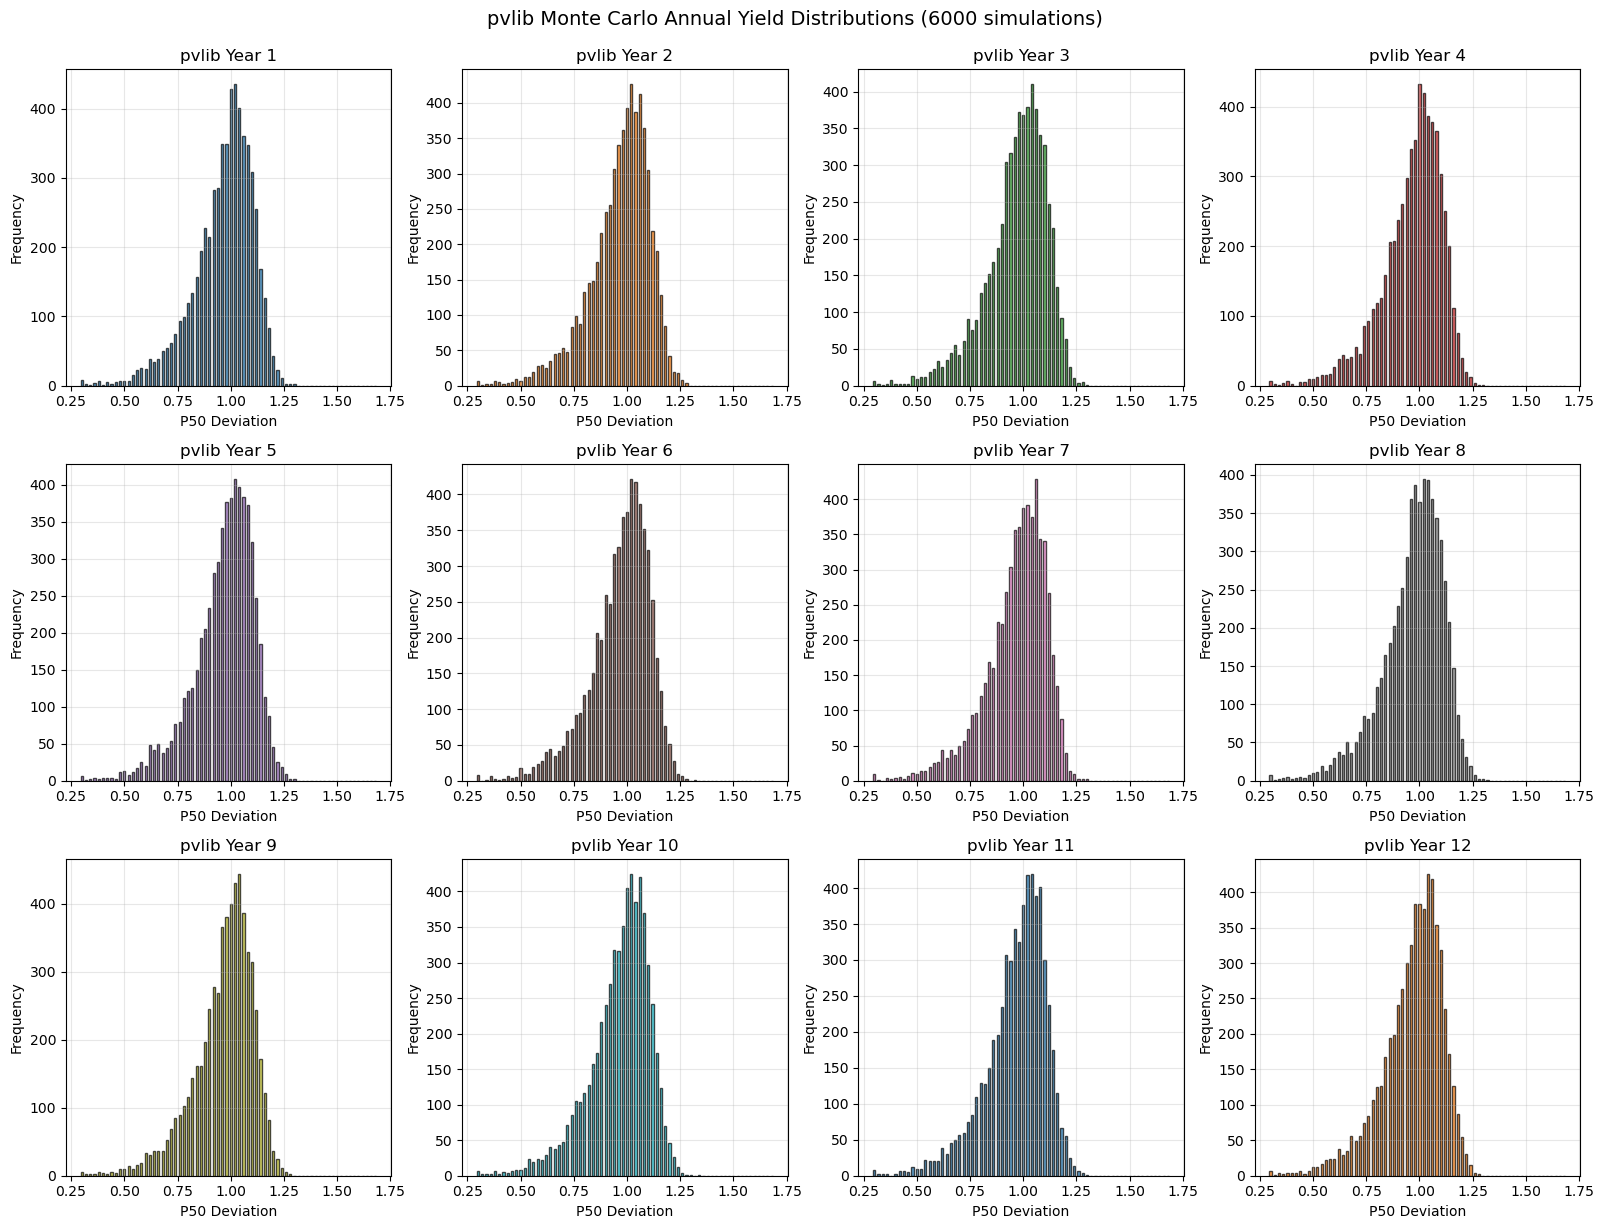

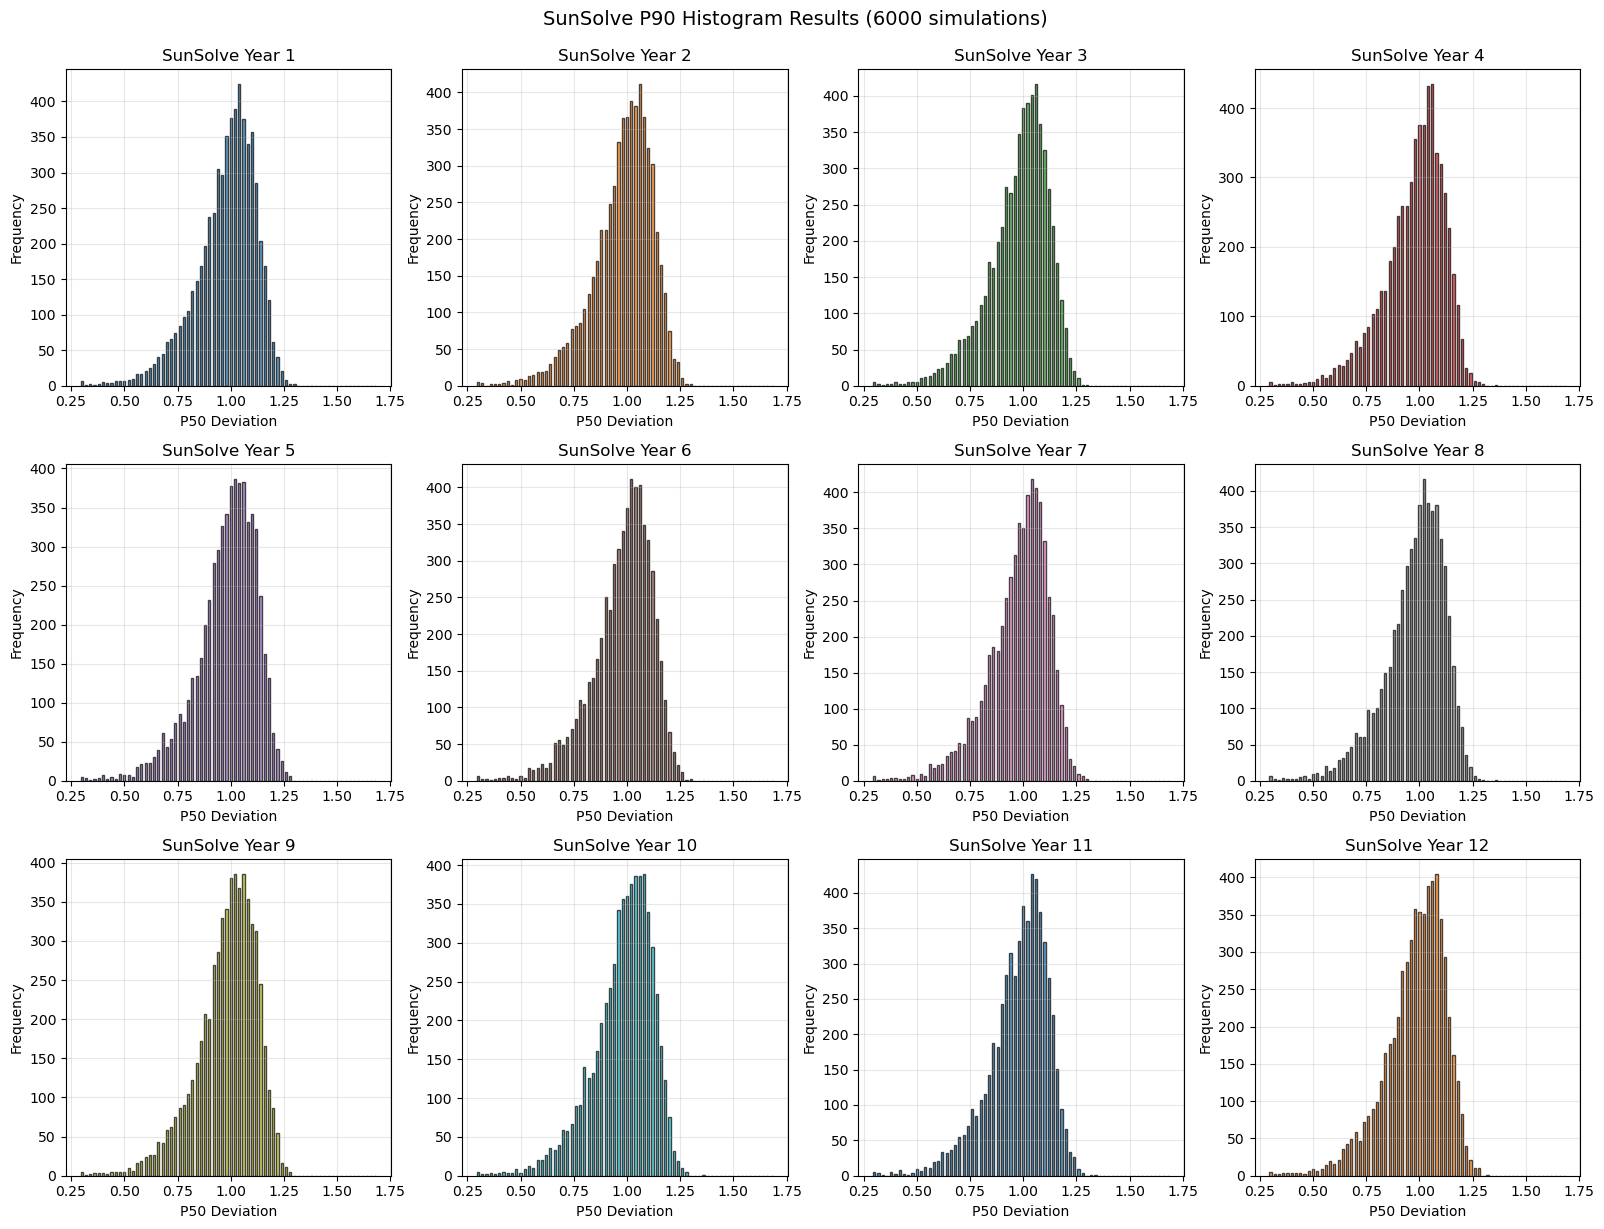

In [203]:
#### P90-pvlib Histogram Comparison
# Create pvlib histogram plots for each year
fig_rows = math.ceil(N_YEARS/fig_cols)
fig1, axes1 = plt.subplots(fig_rows, fig_cols, figsize=(16, 4*N_YEARS//fig_cols))
if N_YEARS > 1:
    axes1 = axes1.flatten()
else:
    axes1 = [axes1]

years = range(1, N_YEARS + 1)
for i, year in enumerate(years):
    if i < len(pvlib_summary.YearlyHistogram):
        # Get pvlib histogram data
        hist_data = pvlib_summary.YearlyHistogram[i]
        bin_counts = np.array(hist_data.bins)

        # Plot pvlib histogram
        axes1[i].bar(p_bins, bin_counts, alpha=0.7, color=f"C{i%10}", edgecolor="black", width=0.01)
        axes1[i].set_title(f"pvlib Year {year}")
        axes1[i].set_xlabel("P50 Deviation")
        axes1[i].set_ylabel("Frequency")
        axes1[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f"pvlib Monte Carlo Annual Yield Distributions ({N_SIMS} simulations)", y=1.02, fontsize=14)
plt.show()


# Store results for comparison
pvlib_results = {
    "annual_yields": annual_yields,
    "yield_mean": yield_mean,
    "yield_p90": yield_p90,
    "yield_p10": yield_p10
}

# Plot SunSolve histograms data
fig2, axes2 = plt.subplots(fig_rows, fig_cols, figsize=(16, 4*N_YEARS//fig_cols))
if N_YEARS > 1:
    axes2 = axes2.flatten()
else:
    axes2 = [axes2]

years = range(1, N_YEARS + 1)
for i, year in enumerate(years):
    if i < len(summary.YearlyHistogram):
        # Get SunSolve histogram data
        hist_data = summary.YearlyHistogram[i]
        bin_counts = np.array(hist_data.bins)
        
        # Plot SunSolve histogram
        axes2[i].bar(p_bins, bin_counts, alpha=0.7, color=f"C{i%10}", edgecolor="black", width=0.01)
        axes2[i].set_title(f"SunSolve Year {year}")
        axes2[i].set_xlabel("P50 Deviation")
        axes2[i].set_ylabel("Frequency")
        axes2[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f"SunSolve P90 Histogram Results ({N_SIMS} simulations)", y=1.02, fontsize=14)
plt.show()

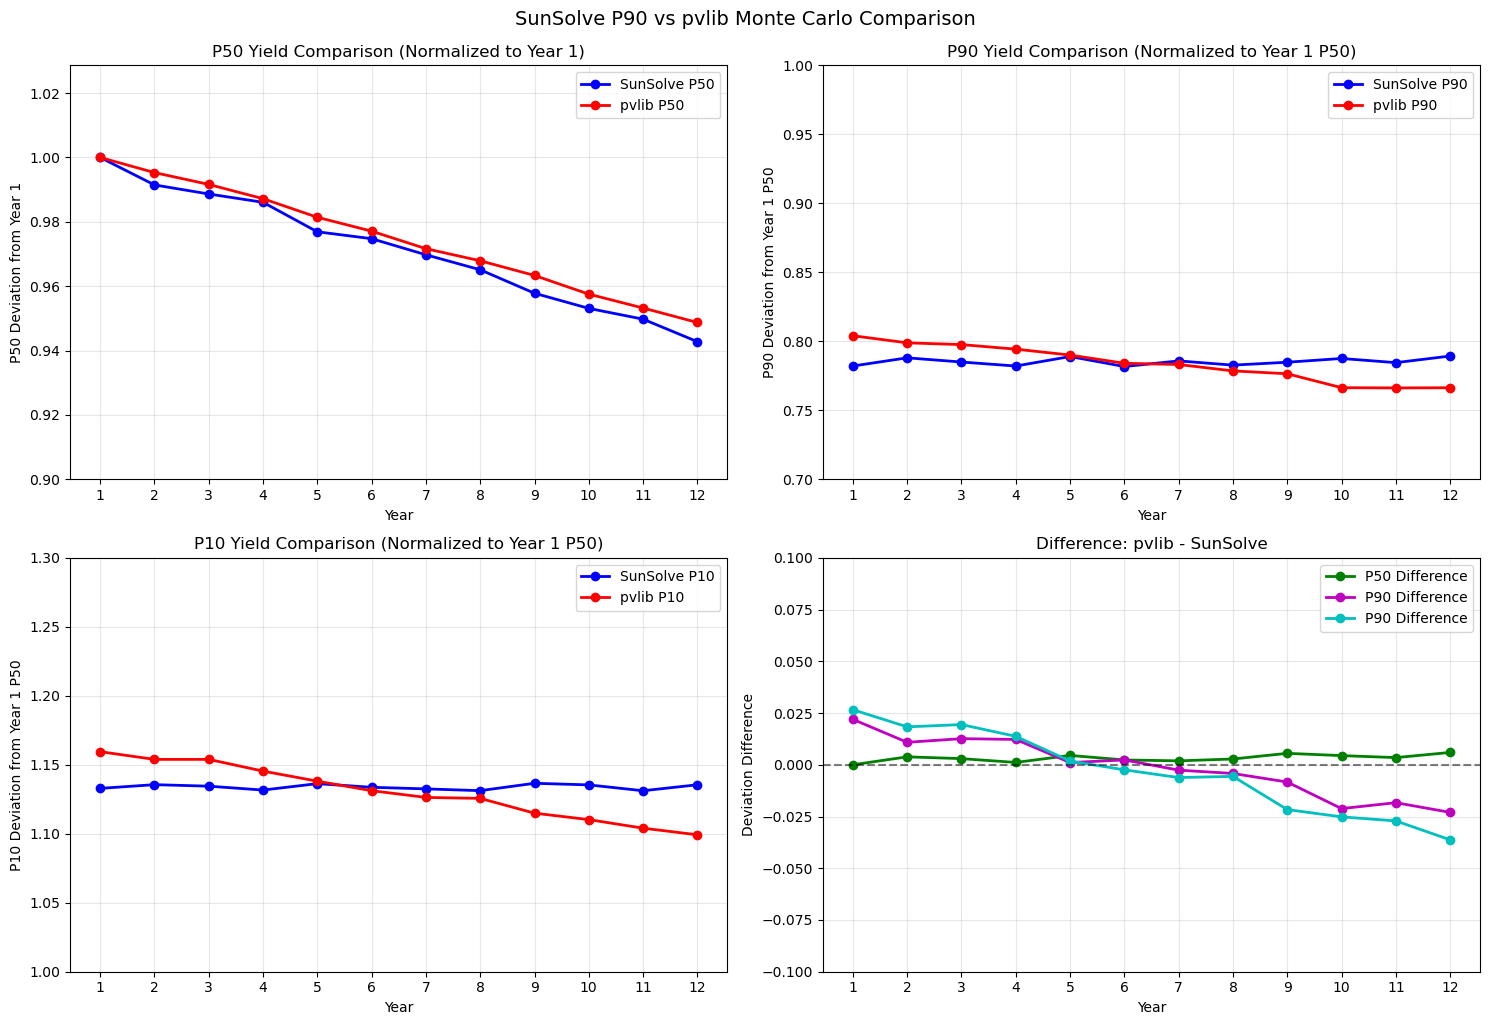


=== Annual Statistics Comparison (kWh) ===
Software	Year	Mean	S.D.	P10	P90	Range
SunSolve	1	989	141	1121	774	347
pvlib		1	989	146	1147	795	352
SunSolve	2	981	140	1114	773	341
pvlib		2	985	145	1141	790	351
SunSolve	3	978	140	1109	768	342
pvlib		3	981	146	1141	789	352
SunSolve	4	975	139	1104	763	341
pvlib		4	976	143	1133	786	347
SunSolve	5	966	138	1098	762	336
pvlib		5	971	143	1126	781	344
SunSolve	6	964	137	1093	754	339
pvlib		6	967	142	1119	776	343
SunSolve	7	959	136	1086	754	333
pvlib		7	961	142	1114	775	339
SunSolve	8	955	136	1080	747	333
pvlib		8	957	142	1113	770	343
SunSolve	9	947	136	1077	744	333
pvlib		9	953	139	1103	768	335
SunSolve	10	943	135	1070	742	328
pvlib		10	947	140	1098	758	340
SunSolve	11	939	133	1063	737	326
pvlib		11	943	140	1092	758	334
SunSolve	12	933	133	1059	736	323
pvlib		12	938	138	1087	758	329

=== Numerical Comparison ===
Year	SunSolve P90	pvlib P90	Diff90
1	0.782		0.804		0.022
2	0.788		0.799		0.011
3	0.785		0.798		0.013
4	0.782		0.794		0.012
5	0.789		0.790	

In [204]:
# Comparison between SunSolve P90 and pvlib Monte Carlo Results
# Extract SunSolve P90 results (normalized values)
sunsolve_p10_deviations = []
sunsolve_p50_deviations = []
sunsolve_p90_deviations = []

# Parse the summary to extract P50 and P90 values for each year
for year in range(N_YEARS):
    # SunSolve results are normalized to P50 deviation
    p50_dev = summary.YearlyP50Deviation[year].Value
    sunsolve_p50_deviations.append(p50_dev)
    
    # Find P90 and P10 values from PValues
    p90_dev, p10_dev = None, None
    
    # YearlyPValue is a flat list: [Y1P50, Y1P90, Y1P95, Y2P50, Y2P90, Y2P95, ...]
    # pvals have '.Year', '.P', and '.P50Deviation' attributes
    for pval in summary.YearlyPValue:
        if pval.Year == year + 1:  # Year is 1-indexed
            if pval.P == 90:
                p90_dev = pval.P50Deviation
            if pval.P == 10:
                p10_dev = pval.P50Deviation
            if p10_dev is not None and p90_dev is not None:
                break
    
    sunsolve_p90_deviations.append(p90_dev)
    sunsolve_p10_deviations.append(p10_dev)

# Calculate pvlib P50 and P90 as deviations from Year 1 P50
pvlib_year_one_p50 = pvlib_results["yield_mean"][0]
pvlib_p50_deviations = pvlib_results["yield_mean"] / pvlib_year_one_p50
pvlib_p10_deviations = pvlib_results["yield_p10"] / pvlib_year_one_p50
pvlib_p90_deviations = pvlib_results["yield_p90"] / pvlib_year_one_p50

p10_diff = np.array(pvlib_p10_deviations) - np.array(sunsolve_p10_deviations)
p50_diff = np.array(pvlib_p50_deviations) - np.array(sunsolve_p50_deviations)
p90_diff = np.array(pvlib_p90_deviations) - np.array(sunsolve_p90_deviations)

# Create comparison plots
# Only works if N_YEARS > 1
if N_YEARS > 1:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    years = np.arange(1, N_YEARS + 1)

    # Plot 1: P50 Comparison
    axes[0,0].plot(years, sunsolve_p50_deviations, "bo-", label="SunSolve P50", linewidth=2, markersize=6)
    axes[0,0].plot(years, pvlib_p50_deviations, "ro-", label="pvlib P50", linewidth=2, markersize=6)
    axes[0,0].set_title("P50 Yield Comparison (Normalized to Year 1)")
    axes[0,0].set_xlabel("Year")
    axes[0,0].set_ylabel("P50 Deviation from Year 1")
    axes[0,0].set_xticks(years)  # Force integer ticks
    all_y_vals = [*sunsolve_p50_deviations, *pvlib_p50_deviations]
    half_y_range = (max(all_y_vals)-min(all_y_vals))/2
    axes[0,0].set_ylim(min(0.9, min(all_y_vals)-half_y_range), max(all_y_vals)+half_y_range)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Plot 2: P90 Comparison
    axes[0,1].plot(years, sunsolve_p90_deviations, "bo-", label="SunSolve P90", linewidth=2, markersize=6)
    axes[0,1].plot(years, pvlib_p90_deviations, "ro-", label="pvlib P90", linewidth=2, markersize=6)
    axes[0,1].set_title("P90 Yield Comparison (Normalized to Year 1 P50)")
    axes[0,1].set_xlabel("Year")
    axes[0,1].set_ylabel("P90 Deviation from Year 1 P50")
    axes[0,1].set_xticks(years)  # Force integer ticks
    all_y_vals = [*sunsolve_p90_deviations, *pvlib_p90_deviations]
    half_y_range = (max(all_y_vals)-min(all_y_vals))/2
    axes[0,1].set_ylim(min(0.7, min(all_y_vals)-half_y_range), max(1, max(all_y_vals)+half_y_range))
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Plot 3: P10 Comparison
    axes[1,0].plot(years, sunsolve_p10_deviations, "bo-", label="SunSolve P10", linewidth=2, markersize=6)
    axes[1,0].plot(years, pvlib_p10_deviations, "ro-", label="pvlib P10", linewidth=2, markersize=6)
    axes[1,0].set_title("P10 Yield Comparison (Normalized to Year 1 P50)")
    axes[1,0].set_xlabel("Year")
    axes[1,0].set_ylabel("P10 Deviation from Year 1 P50")
    axes[1,0].set_xticks(years)  # Force integer ticks
    all_y_vals = [*sunsolve_p10_deviations, *pvlib_p10_deviations]
    half_y_range = (max(all_y_vals)-min(all_y_vals))/2
    axes[1,0].set_ylim(min(1, min(all_y_vals)-half_y_range), max(1.3, max(all_y_vals)+half_y_range))
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Plot 4: Difference between methods
    axes[1,1].plot(years, p50_diff, "go-", label="P50 Difference", linewidth=2, markersize=6)
    axes[1,1].plot(years, p90_diff, "mo-", label="P90 Difference", linewidth=2, markersize=6)
    axes[1,1].plot(years, p10_diff, "co-", label="P90 Difference", linewidth=2, markersize=6)
    axes[1,1].axhline(y=0, color="black", linestyle="--", alpha=0.5)
    axes[1,1].set_title("Difference: pvlib - SunSolve")
    axes[1,1].set_xlabel("Year")
    axes[1,1].set_ylabel("Deviation Difference")
    axes[1,1].set_xticks(years)  # Force integer ticks
    all_y_vals = [*p50_diff, *p90_diff, *p10_diff]
    half_y_range = (max(all_y_vals)-min(all_y_vals))/2
    axes[1,1].set_ylim(min(-0.1, min(all_y_vals)-half_y_range), max(0.1, max(all_y_vals)+half_y_range))
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle("SunSolve P90 vs pvlib Monte Carlo Comparison", y=1.02, fontsize=14)
    plt.show()


# SunSolve and pvlib summary statistics table (scale SunSolve results by the pvlib year 1 P50 to get to kWh)
print(f"\n=== Annual Statistics Comparison (kWh) ===")
print("Software\tYear\tMean\tS.D.\tP10\tP90\tRange")

years = range(1, N_YEARS + 1)
for i, year in enumerate(years):
    # SunSolve row
    sunsolve_mean = pvlib_year_one_p50 * summary.YearlyP50Deviation[i].Value  # SunSolve gives relative values, use pvlib's year 1 P50 and scale everything by it
    # Calculate weighted standard deviation from histogram
    bin_centers = np.array(p_bins)  # These are the bin centers
    frequencies = np.array(summary.YearlyHistogram[i].bins)  # Frequency counts
    total_samples = np.sum(frequencies)
    # Calculate weighted mean and standard deviation
    weighted_mean = np.sum(bin_centers * frequencies) / total_samples
    weighted_variance = np.sum(frequencies * (bin_centers - weighted_mean)**2) / total_samples
    sunsolve_std = np.sqrt(weighted_variance) * sunsolve_mean
    # Scale P10 and P90 values
    sunsolve_p10 = sunsolve_p10_deviations[i] * sunsolve_mean
    sunsolve_p90 = sunsolve_p90_deviations[i] * sunsolve_mean
    print(f"SunSolve\t{year}\t{sunsolve_mean:.0f}\t{sunsolve_std:.0f}\t{sunsolve_p10:.0f}\t{sunsolve_p90:.0f}\t{sunsolve_p10-sunsolve_p90:.0f}")
    
    # pvlib row
    print(f"pvlib\t\t{year}\t{yield_mean[i]:.0f}\t{yield_std[i]:.0f}\t{yield_p10[i]:.0f}\t{yield_p90[i]:.0f}\t{yield_p10[i]-yield_p90[i]:.0f}")

# Print numerical comparison
print("\n=== Numerical Comparison ===")
print("Year\tSunSolve P90\tpvlib P90\tDiff90")
for i, year in enumerate(years):
    print(f"{year}\t{sunsolve_p90_deviations[i]:.3f}\t\t{pvlib_p90_deviations[i]:.3f}\t\t{p90_diff[i]:.3f}")

# Summary statistics
print(f"\n=== Summary Statistics ===")
print(f"P90 Mean Absolute Difference: {np.mean(np.abs(p90_diff)):.4f}")
print(f"P10 Mean Absolute Difference: {np.mean(np.abs(p10_diff)):.4f}")

if N_YEARS > 1:
    print(f"P90 Max Difference: {np.max(np.abs(p90_diff)):.4f}")
    print(f"P10 Max Difference: {np.max(np.abs(p10_diff)):.4f}")
    # Calculate correlation
    from scipy.stats import pearsonr
    p90_corr, p90_p_val = pearsonr(sunsolve_p90_deviations, pvlib_p90_deviations)
    p10_corr, p10_p_val = pearsonr(sunsolve_p10_deviations, pvlib_p10_deviations)

    print(f"\n=== Correlation Analysis ===")
    print(f"P90 Correlation: {p90_corr:.4f} (p-value: {p90_p_val:.4f})")
    print(f"P10 Correlation: {p10_corr:.4f} (p-value: {p10_p_val:.4f})")

In [210]:
# Print notebook to pdf (or html)
# MAKE SURE to SAVE first
import subprocess

# Create results folder if it doesn't exist
results_folder = "P90 Results"
notebook_name = "pvlib_P90_Comparison"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Generate timestamp for filename
timestamp = time.strftime("%y%m%d_%H%M")

# Define notebook and output names
pdf_filename = f"{notebook_name}_{timestamp}.pdf"
pdf_path = os.path.join(results_folder, pdf_filename)

try:
    # Convert notebook to PDF using nbconvert
    cmd = f'jupyter nbconvert --to pdf --output "{pdf_path}" "{notebook_name}.ipynb"'
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    
    if result.returncode == 0:
        print(f"✅ Notebook successfully exported to PDF: {pdf_path}")
    else:
        print(f"❌ Error exporting to PDF: {result.stderr}")
        # Alternative method using HTML
        print("Trying alternative method via HTML...")
        html_path = pdf_path.replace('.pdf', '.html')
        cmd_html = f'jupyter nbconvert --to html --output "{html_path}" *.ipynb'
        subprocess.run(cmd_html, shell=True)
        print(f"📄 HTML version created: {html_path}")
        
except Exception as e:
    print(f"❌ Error: {e}")
    print("💡 Make sure you have nbconvert installed: pip install nbconvert")
    print("💡 For PDF output, you may also need: pip install nbconvert[webpdf]")


✅ Notebook successfully exported to PDF: P90 Results\pvlib_P90_Comparison_251010_0915.pdf
